
<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>


# Laboratorio de Sistemas de Recomendación

## Objetivos del Laboratorio

1.	Implementar y comparar diferentes tipos de sistemas de recomendación utilizando datos reales.

2.	Explorar el impacto de las características de los datos en la calidad de las recomendaciones.

3.	Desarrollar habilidades en preprocesamiento, modelado y evaluación de sistemas de recomendación.


## Los problemas

A lo largo de este laboratorio deberás enfrentarte a distintos casos prácticos:

- **Caso 1: Sistema de Recomendación Basado en Contenido**

	Debes construir un sistema que recomiende videojuegos similares basándose en su descripción y géneros. Para eso deberás:

	- Preprocesar las descripciones de los juegos (texto) utilizando técnicas de NLP aprendidas durante la clase.

	- Extraer y limpiar las etiquetas de género para su uso en el sistema de recomendación.

	- Implementar una métrica de similitud (como el coseno) para recomendar juegos similares.

	- Evaluar las recomendaciones generadas para un conjunto de juegos específicos.

- **Caso 2: Sistema de Recomendación Basado en Popularidad**

	Debes un sistema que recomiende los juegos más populares según su calificación general y número de reseñas. Para eso deberás:
	
	- Limpiar y convertir las columnas relacionadas con las calificaciones y las reseñas en datos numéricos.
	
	- Identificar los juegos más populares utilizando métricas como la mediana de calificaciones ponderadas.
	
	- Crear una tabla de recomendaciones generales para diferentes géneros.

## Los Datos


- **1. games_description.csv**: Este archivo contiene información detallada sobre videojuegos disponibles en una tienda. Las columnas que tenemos son: 


	- **`name`**: Nombre del videojuego.

	- **`short_description`**: Breve descripción del videojuego.

	- **`long_description`**: Descripción completa y detallada del videojuego.

	- **`genres`**: Lista de géneros asociados al videojuego (por ejemplo, Acción, RPG).

	- **`minimum_system_requirement`**: Requisitos mínimos para ejecutar el videojuego.

	- **`recommend_system_requirement`**: Requisitos recomendados para ejecutar el videojuego.

	- **`release_date`**: Fecha de lanzamiento del videojuego.

	- **`developer`**: Nombre del desarrollador del videojuego.

	- **`publisher`**: Nombre del publicador del videojuego.

	- **`overall_player_rating`**: Calificación general de los jugadores (categórica).

	- **`number_of_reviews_from_purchased_people`**: Número de reseñas realizadas por personas que compraron el juego.

	- **`number_of_english_reviews`**: Número de reseñas en inglés.

	- **`link`**: Enlace al videojuego en la tienda.


- **2. games_ranking.csv**: Este archivo contiene información sobre el ranking de videojuegos basados en diferentes métricas. Las columnsa que tenemos son:


	- **`game_name`**: Nombre del videojuego.

	- **`genre`**: Género principal del videojuego.

	- **`rank_type`**: Tipo de ranking (por ejemplo, ventas, popularidad).

	- **`rank`**: Posición del videojuego en el ranking correspondiente.

----

- Los datos del archivo `games_description.csv` pueden utilizarse para construir sistemas de recomendación basados en contenido.
- Los datos del archivo `games_ranking.csv` son ideales para implementar sistemas basados en popularidad.


In [93]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd

# Para visualización de datos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Para cargar los datos
# -----------------------------------------------------------------------
import pickle

# Para sistemas de recomendacion basados en cotenido
# -----------------------------------------------------------------------
from scipy.spatial.distance import pdist , squareform   # Para calcular la distancia entre puntos 
from sklearn.feature_extraction.text import CountVectorizer # Vectorizacion / tokenizacion 
from sklearn.metrics.pairwise import cosine_similarity #  Cosine Similarity post Vectorizacion

# Importamos nuestras funciones
# -----------------------------------------------------------------------
from src import soporte_sistemas_recomendacion as sr

# Configuración de pandas
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None)

## Importación de los datos

In [94]:
df_description = pd.read_csv("datos/games_description.csv")
df_description.head(1)

,name,short_description,long_description,genres,minimum_system_requirement,recommend_system_requirement,release_date,developer,publisher,overall_player_rating,number_of_reviews_from_purchased_people,number_of_english_reviews,link
0,Black Myth: Wukong,Black Myth: Wukong is an action RPG rooted in ...,About This Game\n\t\t\t\t\t\t\tBlack Myth: Wuk...,"['Mythology', 'Action RPG', 'Action', 'RPG', '...",['Requires a 64-bit processor and operating sy...,['Requires a 64-bit processor and operating sy...,"19 Aug, 2024",['Game Science'],['Game Science'],Overwhelmingly Positive,"(654,820)","51,931",https://store.steampowered.com/app/2358720/Bla...


In [95]:
df_ranking = pd.read_csv("datos/games_ranking.csv")
df_ranking.head(1)

,game_name,genre,rank_type,rank
0,Counter-Strike 2,Action,Sales,1


## Sistemas de recomendación basados en contenido

### Merge de los dataframes

In [96]:
df_ranking.rename(columns = {'game_name':'name'}, inplace=True)

In [97]:
df_completo = pd.merge(right=df_description, left=df_ranking, right_on="name", left_on="name", how="outer")

- Comprobamos los shapes

In [98]:
print(df_description.shape)
print(df_ranking.shape)
print(df_completo.shape)

(290, 13)
(672, 4)
(672, 16)


In [99]:
df_completo.head(1)

,name,genre,rank_type,rank,short_description,long_description,genres,minimum_system_requirement,recommend_system_requirement,release_date,developer,publisher,overall_player_rating,number_of_reviews_from_purchased_people,number_of_english_reviews,link
0,69 Balls,Sports & Racing,Review,11,A Third-Person shooting game but you are not a...,About This Game\nA Third-Person shooting game ...,"['Pool', 'Football (Soccer)', 'Multiplayer', '...",['Requires a 64-bit processor and operating sy...,['Requires a 64-bit processor and operating sy...,"16 Jun, 2023","['Matthew Choi', 'Plum Point 2']",['GKStudio'],Very Positive,(91% of 143) All Time,120,https://store.steampowered.com/app/2335720/69_...


In [100]:
df_completo['long_description'][7]

'About This Game\n\t\t\t\t\t\t\tAge of Empires II: Definitive Edition celebrates the 20th anniversary of one of the most popular strategy games ever, now with stunning 4K Ultra HD graphics, and a fully remastered soundtrack.  Age of Empires II: DE features “The Last Khans” with 3 new campaigns and 4 new Civilizations. Frequent updates include events, additional content, new game modes, and enhanced features with the recent addition of Co-Op mode!Explore all the original Campaigns and the best-selling expansions like never before.  With over 200 hours of gameplay and 1,000 years of human history, improved experiences await.  Head online to challenge other players in your quest for world domination with 35 different Civilizations. You can also experience new Civilizations and Campaigns with the Lords of the West DLC!  Recent updates include a Battle Royale game mode, ongoing support for the Scenario Editor, Quick Play for easy social games, enhancements to the game UI, and more! Choose y

### Limpieza de las columnas

- Como primer paso, vamos a eliminar los corchetes y las comillas de las columnas que parecen tener listas, aunque, en realidad, se corresponden con strings.

- En la columna long description, sustituiremos la parte inicial del string.

In [101]:
# si fueran listas, pero son simplemente strings con formato de lista
#df_completo['columna'].apply(lambda x: ', '.join(x))

columnas_apply = ['genres', 'developer', 'publisher', 'minimum_system_requirement', 'recommend_system_requirement']

for columna in columnas_apply:
    df_completo[columna] = df_completo[columna].apply(lambda x: str(x).replace('[', '').replace(']', '').replace("'", ''))

df_completo['long_description'] = df_completo['long_description'].apply(lambda x: str(x).replace('About This Game\n\t\t\t\t\t\t\t', '').replace('About This Game\n', ''))

In [102]:
df_completo.head(1)

,name,genre,rank_type,rank,short_description,long_description,genres,minimum_system_requirement,recommend_system_requirement,release_date,developer,publisher,overall_player_rating,number_of_reviews_from_purchased_people,number_of_english_reviews,link
0,69 Balls,Sports & Racing,Review,11,A Third-Person shooting game but you are not a...,A Third-Person shooting game but you are not a...,"Pool, Football (Soccer), Multiplayer, PvP, Fun...",Requires a 64-bit processor and operating syst...,Requires a 64-bit processor and operating system,"16 Jun, 2023","Matthew Choi, Plum Point 2",GKStudio,Very Positive,(91% of 143) All Time,120,https://store.steampowered.com/app/2335720/69_...


- Vamos a sustituir los valores categóricos en el 'overall_player_rating' por equivalentes numéricos.

In [103]:
map_rating = {
    'Very Positive': 9, 
    'Overwhelmingly Positive': 10, 
    'Positive': 8, 
    'Mixed': 7,
    'Mostly Positive': 6, 
    'Mostly Negative': 5, 
    'Very Negative': 4,
    '7 user reviews': 7, 
    '6 user reviews': 7, 
    '1 user reviews': 7,
    '4 user reviews': 7
}

df_completo['overall_player_rating'] = df_completo['overall_player_rating'].replace(map_rating)

/var/folders/yj/y1bv8zk12j11bnjq1hc6x_d80000gn/T/ipykernel_15388/2574526777.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_completo['overall_player_rating'] = df_completo['overall_player_rating'].replace(map_rating)


In [104]:
df_completo.head(1)

,name,genre,rank_type,rank,short_description,long_description,genres,minimum_system_requirement,recommend_system_requirement,release_date,developer,publisher,overall_player_rating,number_of_reviews_from_purchased_people,number_of_english_reviews,link
0,69 Balls,Sports & Racing,Review,11,A Third-Person shooting game but you are not a...,A Third-Person shooting game but you are not a...,"Pool, Football (Soccer), Multiplayer, PvP, Fun...",Requires a 64-bit processor and operating syst...,Requires a 64-bit processor and operating system,"16 Jun, 2023","Matthew Choi, Plum Point 2",GKStudio,9.0,(91% of 143) All Time,120,https://store.steampowered.com/app/2335720/69_...


- Comprobamos que los short_descriptions tengan longitudes similares

In [105]:
df_completo['short_description'] = df_completo['short_description'].astype(str)
for row in df_completo.short_description:
    print(len(row))

241
228
228
283
211
159
240
240
263
169
169
232
272
276
130
3
3
3
210
210
277
277
277
3
84
245
245
245
245
284
284
3
298
271
186
186
186
186
186
186
294
294
294
294
3
3
226
187
187
207
207
207
207
207
207
193
83
83
83
297
297
297
297
297
235
235
235
235
235
235
235
235
235
163
163
163
94
94
152
152
176
130
130
149
3
3
138
280
152
152
152
232
232
232
3
3
155
155
155
266
266
287
287
287
287
191
182
182
3
224
224
224
3
288
288
288
262
262
262
262
262
262
262
3
178
178
178
178
178
178
3
3
3
3
176
252
252
139
139
296
3
3
243
243
243
213
257
65
65
65
65
218
218
218
176
214
214
126
126
126
126
90
217
149
149
149
239
239
260
319
319
319
319
319
319
319
319
319
264
275
275
275
275
192
106
229
284
284
284
284
176
176
215
215
215
215
205
205
205
205
212
212
171
171
171
171
171
171
3
3
3
3
232
211
211
211
247
247
154
154
257
257
261
261
261
261
261
210
210
210
210
210
213
244
45
3
189
202
202
202
164
164
210
201
201
201
201
201
201
201
297
297
275
275
275
275
150
265
121
230
188
298
298
131
185
18

- Comprobamos si hay valores nulos.

In [106]:
df_completo.isna().sum()

name                                        0
genre                                       0
rank_type                                   0
rank                                        0
short_description                           0
long_description                            0
genres                                      0
minimum_system_requirement                  0
recommend_system_requirement                0
release_date                               16
developer                                   0
publisher                                   0
overall_player_rating                      16
number_of_reviews_from_purchased_people    16
number_of_english_reviews                  16
link                                       16
dtype: int64

### Nueva columna objetivo

- Vamos a crear una nueva columna que contenga los géneros y las descripciones cortas.

In [107]:
df_completo['tags'] = df_completo['genres']+' '+df_completo['short_description']

In [108]:
df_completo['tags'][0]

"Pool, Football (Soccer), Multiplayer, PvP, Funny, Team-Based, eSports, Third Person, Sports, Action, Mini Golf, Football (American), Simulation, RTS, Shooter, Real Time Tactics, Third-Person Shooter, 3D, Cartoony, Free to Play A Third-Person shooting game but you are not a person. You are a BALL! Imagine a pool ball, a shotgun and football mechanics mashed together! You said you can't? Neither do I! Just shoot everything you see and pray if the black ball goes in!"

### Vectorización

In [109]:
# Realizamos la vectorización, es decir, convertimos el texto a vectores para poder calcular las distancias entre contenidos
vectorizer = CountVectorizer(max_features=1000, stop_words= "english")

# Vectorizamos la columna objetivo
X = vectorizer.fit_transform(df_completo['tags']).toarray()

# Calculamos sus distancias
similarity = cosine_similarity(X)
similarity[:10]

array([[1.        , 0.14554543, 0.14554543, ..., 0.15923244, 0.15923244,
        0.        ],
       [0.14554543, 1.        , 1.        , ..., 0.38682107, 0.38682107,
        0.        ],
       [0.14554543, 1.        , 1.        , ..., 0.38682107, 0.38682107,
        0.        ],
       ...,
       [0.09901475, 0.14847847, 0.14847847, ..., 0.10721125, 0.10721125,
        0.        ],
       [0.09811049, 0.2795327 , 0.2795327 , ..., 0.21246427, 0.21246427,
        0.        ],
       [0.10502101, 0.14173668, 0.14173668, ..., 0.11371471, 0.11371471,
        0.        ]])

In [110]:
# Renombramos la columna name a title
df_completo.rename(columns = {'name':'title'}, inplace=True)

# Definimos el contenido que le gusta al usuario para poder realizar las recomendaciones
user_likes = 'God of War'

# Buscamos el índice del contenido, ya que lo vamos a necesitar para nuestro objetivo
content_index = sr.get_index_from_title(user_likes, df_completo)

# Extraemos los contenidos similares
similar_content = list(enumerate(similarity[content_index]))
similar_content[:3]

[(0, np.float64(0.1395541389950575)),
 (1, np.float64(0.26906100125031573)),
 (2, np.float64(0.26906100125031573))]

In [111]:
content_sorted = sorted(similar_content,key=lambda x:x[1],reverse=True)[1:21] # [1:21] si lo cambiamos a [0:21] la tenemos a ella misma 
content_sorted[:3]

[(290, np.float64(0.6515081921686976)),
 (64, np.float64(0.6157262743072357)),
 (65, np.float64(0.6157262743072357))]

/var/folders/yj/y1bv8zk12j11bnjq1hc6x_d80000gn/T/ipykernel_15388/3670568614.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


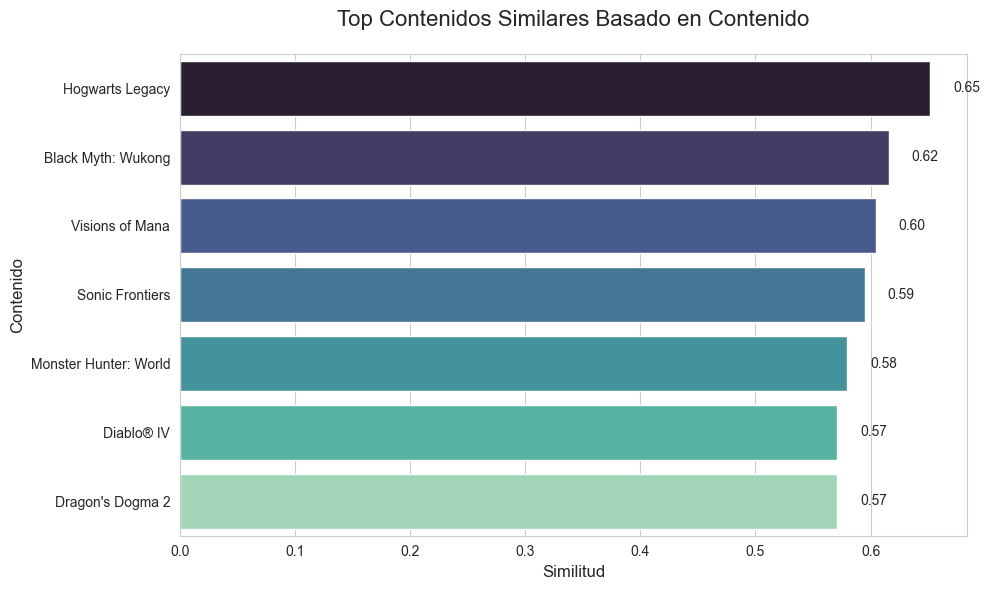

In [112]:
# Buscamos el título
top_similar_content = {}
for i in content_sorted:
    top_similar_content[sr.get_title_from_index(i[0], df_completo)] = i[1]

# Visualizamos los resultados
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Creamos gráfico de barras
sns.barplot(
    x=list(top_similar_content.values()), 
    y=list(top_similar_content.keys()), 
    palette="mako"
)

# Añadimos etiquetas y título
plt.title("Top Contenidos Similares Basado en Contenido", fontsize=16, pad=20)
plt.xlabel("Similitud", fontsize=12)
plt.ylabel("Contenido", fontsize=12)

# Añadimos valores al final de cada barra
for i, value in enumerate(top_similar_content.values()):
    plt.text(value + 0.02, i, f"{value:.2f}", va='center', fontsize=10)

plt.tight_layout()


## Sistemas de recomendación basados en popularidad

In [113]:
df_completo.head(1)

,title,genre,rank_type,rank,short_description,long_description,genres,minimum_system_requirement,recommend_system_requirement,release_date,developer,publisher,overall_player_rating,number_of_reviews_from_purchased_people,number_of_english_reviews,link,tags
0,69 Balls,Sports & Racing,Review,11,A Third-Person shooting game but you are not a...,A Third-Person shooting game but you are not a...,"Pool, Football (Soccer), Multiplayer, PvP, Fun...",Requires a 64-bit processor and operating syst...,Requires a 64-bit processor and operating system,"16 Jun, 2023","Matthew Choi, Plum Point 2",GKStudio,9.0,(91% of 143) All Time,120,https://store.steampowered.com/app/2335720/69_...,"Pool, Football (Soccer), Multiplayer, PvP, Fun..."


In [114]:
df_completo.dropna(inplace=True)

In [115]:
df_completo['number_of_english_reviews'] = df_completo['number_of_english_reviews'].str.replace(',','').astype(int)
df_filtrado = df_completo[['title', 'genre', 'overall_player_rating', 'number_of_english_reviews']]

In [116]:
df_filtrado.head()

,title,genre,overall_player_rating,number_of_english_reviews
0,69 Balls,Sports & Racing,9.0,120
1,7 Days to Die,Simulation,9.0,158982
2,7 Days to Die,Simulation,9.0,158982
3,ARK: Survival Ascended,Adventure,7.0,36814
4,ARK: Survival Evolved,Action,9.0,310038


In [117]:
df_groupby = df_filtrado.groupby(by = ["title", "genre"])[['overall_player_rating', 'number_of_english_reviews']].median()
df_groupby = df_groupby[1:10]
df_groupby.reset_index(inplace=True)

<Axes: xlabel='title', ylabel='overall_player_rating'>

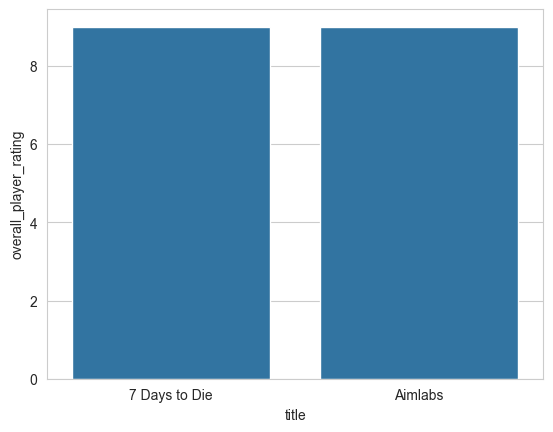

In [118]:
sns.barplot(df_groupby[df_groupby["genre"] == "Simulation"], x="title", y="overall_player_rating")

## Tabla de recomendaciones

In [119]:
df_groupby2 = df_filtrado.groupby(by = ["title", "genre"])[['overall_player_rating', 'number_of_english_reviews']].median()
df_groupby2.reset_index(inplace=True)

- Para una nueva recomendación de género, cambia el género en la variable género, eligiendo entre 'Sports & Racing', 'Simulation', 'Adventure', 'Action', 'Strategy', 'Role-Playing'.

In [ ]:
genero = "Action"
sr.recomiendame_un_yanru(df_groupby2, "genre", genero)

,title,genre,overall_player_rating,number_of_english_reviews
17,Among Us,Action,9.0,406705.0
20,Apex Legends™,Action,7.0,406269.0
32,Battlefield™ V,Action,6.0,34879.0
34,Black Desert,Action,6.0,46936.0
37,Black Myth: Wukong,Action,10.0,51931.0
41,Borderlands 2,Action,10.0,159122.0
43,Call of Duty®,Action,7.0,299267.0
44,Call of Duty®: Black Ops II,Action,9.0,21097.0
45,Call of Duty®: Black Ops III,Action,9.0,145713.0
